# LCA OWM in Montreal

# 1. Setup project

In [2]:
import brightway2 as bw
import os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

In [3]:
bw.projects.set_current('testproject6')

# 2. Database import (only have to do once or if you want to load an updated database)

Import ecoinvent

In [3]:
bw.import_ecoinvent_release('3.9.1', 'cutoff','ebenezer.kwofie@mcgill.ca', '2EBz*!#0DCH4')

NameError: name 'bw' is not defined

Import own data

In [9]:
#import OWM facilities database
imp = bw.ExcelImporter(r"Canada OWM Facilities Database.xlsx") # the path to your inventory excel file
imp.apply_strategies()
imp.match_database("ecoinvent-3.9.1-cutoff", fields=('name', 'unit', 'location', 'reference product')) # 'reference product'
imp.match_database(fields=('name', 'unit', 'location'))
imp.statistics()
imp.write_excel(only_unlinked=True)
list(imp.unlinked)
imp.write_database()

Extracted 3 worksheets in 0.03 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 5.07 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
16 datasets
140 exchanges
19 unlinked exchanges
  Type biosphere: 1 unique unlinked exc

InvalidExchange: 

In [10]:
#import scenarios database
imp = bw.ExcelImporter(r"Scenarios Database.xlsx") # the path to your inventory excel file
imp.apply_strategies()
imp.match_database("OWM Facilities", fields=('name', 'unit', 'location', 'reference product')) # 'reference product'
imp.match_database(fields=('name', 'unit', 'location'))
imp.statistics()
imp.write_excel(only_unlinked=True)
list(imp.unlinked)
imp.write_database()

Extracted 1 worksheets in 0.02 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 4.82 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
3 datasets
26 exchanges
0 unlinked exchanges
  
Wrote matching file to:
/Users/yonatanb

In [11]:
#check if it imported properly
list(bw.databases)

['biosphere3',
 'ecoinvent-3.9.1-biosphere',
 'ecoinvent-3.9.1-cutoff',
 'OWM Facilities',
 'Scenarios',
 'OWM LCA']

In [ ]:
# to delete a database

# 3. Set up scenarios

In [15]:
LCAdb =  bw.Database('Scenarios')
S1 = [a for a in LCAdb if 'S1' in a ['name']]
S2 = [a for a in LCAdb if 'S2' in a ['name']]
S3 = [a for a in LCAdb if 'S3' in a ['name']]
acts = S1[0], S2[0], S3[0]
acts

('S1' (tonne, CA-QC, None),
 'S2' (tonne, CA-QC, None),
 'S3' (tonne, CA-QC, None))

# 4. Choose an impact assessment method

In [13]:
CC_method = [m for m in bw.methods if 'IPCC 2021' in str(m) and not 'LT' in str(m) and 'GWP100' in str(m) and 'climate change' in str(m) and not 'biogenic' in str(m) and not 'fossil' in str(m) and not 'land use' in str(m) and not 'SLCFs' in str(m)]
CC_method

[('IPCC 2021', 'climate change', 'global warming potential (GWP100)')]

# 5. Calculate LCA

5.1 MultiLCA

In [14]:
FU = [{x:1} for x in acts] #functional unit
bw.calculation_setups['OWM_Scenarios'] = {'inv':FU, 'ia': CC_method}
mylca = bw.MultiLCA('OWM_Scenarios')
mylca.results

/opt/anaconda3/envs/bw/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.55e+12)
  warnings.warn(msg, UmfpackWarning)


array([[325.09144154],
       [340.34099712],
       [365.20545714]])

5.2 Single process LCA

In [ ]:
act = S1[0]


In [ ]:
lca = bw.LCA({act:1},CC_method)
lca.lci()
lca.lcia()
lca.score

1037.3276654999545

In [ ]:
{k:v for k,v in zip(CC_method, mylca.results)}

{('IPCC 2021',
  'climate change',
  'global warming potential (GWP100)'): array([1037.3276655])}

5.3 display results

In [ ]:
mylcadf = pd.DataFrame(index = CC_method, columns = [(x['name']) for y in FU for x in y], data=mylca.results.T)
mylcadf

,S1,S2,S3
"(IPCC 2021, climate change, global warming potential (GWP100))",1037.327665,710.543747,369.835749


optional

In [ ]:
mylcadf.to_excel('lcia_results.xlsx') # export to excel, e.g. for creating figures

In [ ]:
acts

('S1' (tonne, CA-QC, None),
 'S2' (tonne, CA-QC, None),
 'S3' (tonne, CA-QC, None))

In [ ]:
CC_method

[('IPCC 2021', 'climate change', 'global warming potential (GWP100)')]

In [ ]:
#short names
labels_methods = {
    ('IPCC 2013', 'climate change', 'GWP 100a'): 'IPCC 2013',    
}
labels_act = {
    ('S1', 'CA-QC'):'S1',
    ('S2', 'CA-QC'):'S2',
    ('S3', 'CA-QC'):'S2',
}

In [ ]:
#see updates labels
mylcadf

,S1,S2,S3
"(IPCC 2021, climate change, global warming potential (GWP100))",1037.327665,710.543747,369.835749


In [ ]:
df = mylcadf.rename(columns=labels_act, index=labels_methods)
df

,S1,S2,S3
"(IPCC 2021, climate change, global warming potential (GWP100))",1037.327665,710.543747,369.835749


<Axes: xlabel='Impact category', ylabel='Impact score (kg CO2-eq)'>

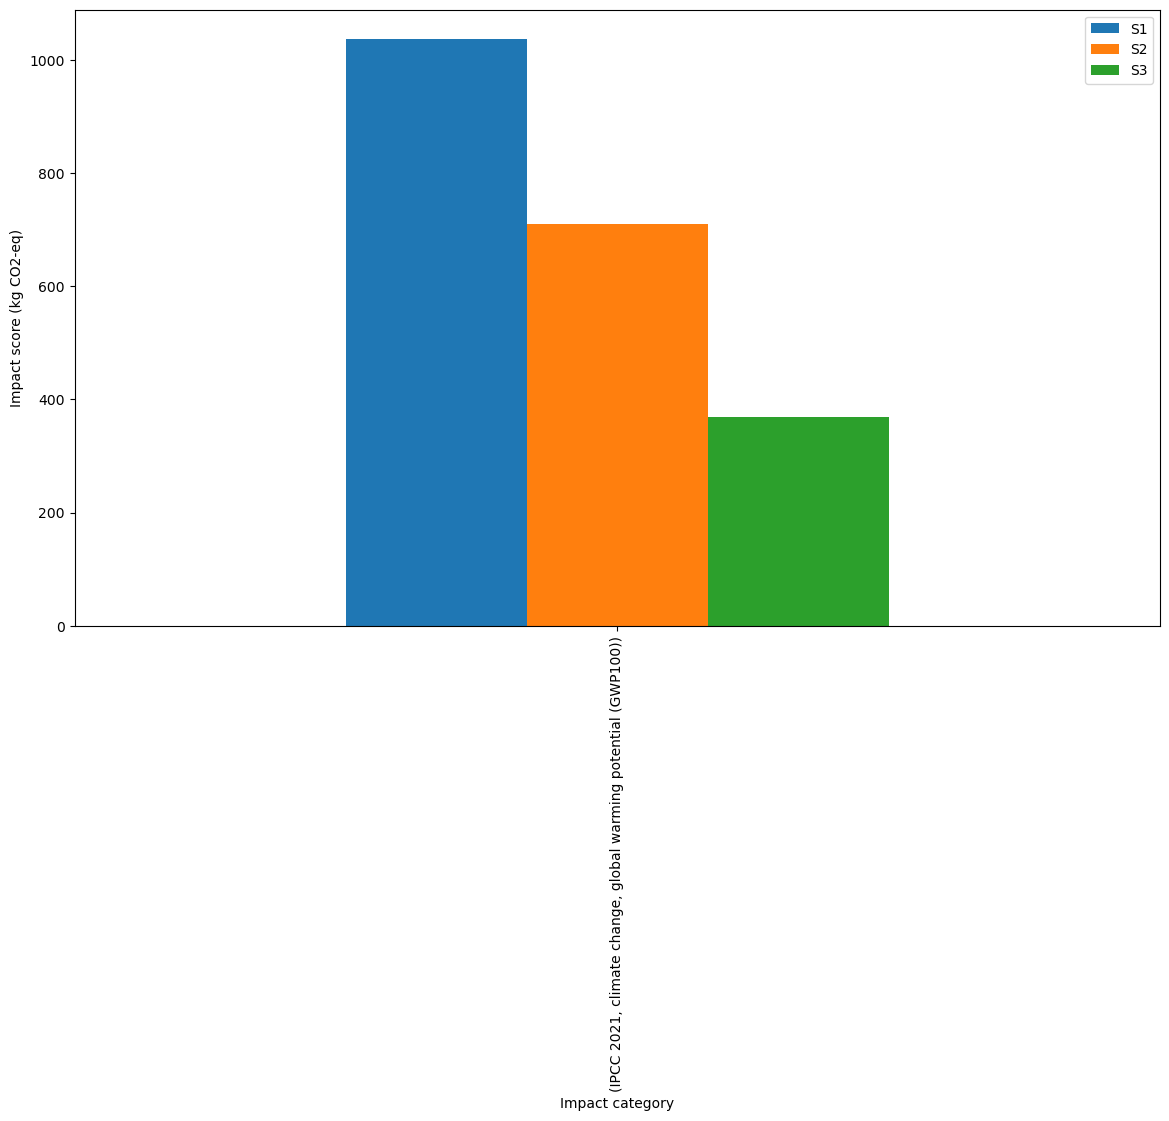

In [ ]:
df.plot.bar(
    xlabel='Impact category',
    ylabel='Impact score (kg CO2-eq)',
    figsize=(14,8)
)

# 6. Contribution analysis

Adapted from: 
https://github.com/massimopizzol/advanced-lca-notebooks/blob/main/Specific-bw-tasks/Contribution-analysis-foreground-by-activity.ipynb

to do: how can I get it to show the activity name instead of key? has to do with act['code']

In [11]:
# Forthe first activity in the list
act = bw.Database(acts[0]['database']).get(acts[0]['code'])
print(act)

'S1' (tonne, CA-QC, None)


In [12]:
functional_unit = {act: 1} 
mymethod = CC_method[0]
lca = bw.LCA(functional_unit, mymethod)
lca.lci()
lca.lcia()
print(lca.score)

1037.3276654999545


In [13]:
def dolcacalc(act, mydemand, mymethod):
    my_fu = {act: mydemand} 
    lca = bw.LCA(my_fu, mymethod)
    lca.lci()
    lca.lcia()
    return lca.score

# For WtT
def getLCAresults(list_acts, mymethod):
    
    all_activities = []
    results = []
    for a in list_acts:
        act = bw.Database(a[0]).get(a[1])
        print(act)
        all_activities.append(act['name'])
        results.append(dolcacalc(act,1,mymethod)) # 1 stays for one unit of each process
        #print(act['name'])
     
    results_dict = dict(zip(all_activities, results))
    
    return results_dict

In [14]:
ca_dict = {}

for act in acts:
    
    exc_list = []
    contr_list = []

    for exc in list(act.exchanges()):
        
        if exc['type'] == 'biosphere':
            
            col = lca.activity_dict[exc['output']] # find column index of A matrix for the activity
            row = lca.biosphere_dict[exc['input']] # find row index of B matrix for the exchange
            contr_score = lca.biosphere_matrix[row,col] * lca.characterization_matrix[row,row]
            contr_list.append((exc['input'],exc['type'], exc['amount'], contr_score))
            
        elif exc['type'] == 'substitution':
            
            contr_score = dolcacalc(bw.Database(exc['input'][0]).get(exc['input'][1]), exc['amount'], mymethod)
            contr_list.append((exc['name'],exc['input'], exc['type'], exc['amount'], contr_score))
            
        else:
            
            contr_score = dolcacalc(bw.Database(exc['input'][0]).get(exc['input'][1]), exc['amount'], mymethod)
            contr_list.append((exc['name'], exc['input'], exc['type'], exc['amount'], contr_score))
        
    ca_dict[act['name']] =  contr_list

In [15]:
getLCAresults(acts, mymethod)

'S1' (tonne, CA-QC, None)
'S2' (tonne, CA-QC, None)
'S3' (tonne, CA-QC, None)


{'S1': 1037.3276654999545, 'S2': 710.5437472012873, 'S3': 369.83574899307246}

Check if sum of all exchanges equals the production impact

In [17]:
print(df.loc[df['type'] == 'production']['contribution'].sum())
print(df.loc[df['type'] != 'production']['contribution'].sum())

1037.3276654999545
1037.3276822634796


In [18]:
contribution_tables = {}  # Dictionary to store tables for each scenario

for act in acts:
    name = act['name']
    df = pd.DataFrame(ca_dict[name], columns=['name', 'input', 'type', 'amount', 'contribution'])

    # Calculate % contribution
    production_total = df.loc[df['type'] == 'production', 'contribution'].sum()
    df['%_contribution'] = 100 * df['contribution'] / production_total

    # Optional: sort by contribution or % if you want
    df = df.sort_values(by='contribution', ascending=False)

    # Save to dictionary
    contribution_tables[name] = df

    # Print or preview
    print(f"\n--- Contribution table for {name} ---")
    display(df.head(10))  # Show top 10 contributors (optional)


--- Contribution table for S1 ---


,name,input,type,amount,contribution,%_contribution
0,S1,"(Scenarios, 37030519024861417916dae7bfac124c)",production,1.000000,1037.327665,100.000000
10,Composter_saint thomas,"(OWM Facilities, 6f29bbf95a1b8057e9d45e90554d7...",technosphere,0.156168,321.191070,30.963319
7,Composter_casselman,"(OWM Facilities, eeb262dba20ea97b736f102578f01...",technosphere,0.076349,157.902702,15.222066
8,Composter_complexe enviro st Michel,"(OWM Facilities, 52dbb59d7cef099d0fe5a7d558462...",technosphere,0.065938,135.294684,13.042618
3,Landfill_saint_thomas,"(OWM Facilities, 0108f8e3577efb4d3a410a80c82be...",technosphere,0.248125,123.086135,11.865695
2,Landfill_terrebonne,"(OWM Facilities, 6e99a20c02ccf2d95d78403219c6e...",technosphere,0.208947,102.696050,9.900059
9,Composter_terrebonne,"(OWM Facilities, dfc455135f96be2fc69fe163de47a...",technosphere,0.048586,99.703948,9.611616
1,Landfill_saint sophie,"(OWM Facilities, f7a98f487bfc93c9a0ee9abc08a8c...",technosphere,0.124062,61.428321,5.921786
6,Landfill_cecile_de_milton,"(OWM Facilities, 3af7ac46474917a220a18cf30ce12...",technosphere,0.026118,13.083237,1.261244
4,Landfill_lachute,"(OWM Facilities, 09764f3bd90940ca1a5187a467a25...",technosphere,0.026118,13.059894,1.258994



--- Contribution table for S2 ---


,name,input,type,amount,contribution,%_contribution
0,S2,"(Scenarios, 37f84d7011f7b619bac6535fa43c3e69)",production,1.000000,710.543747,100.000000
7,Composter_saint thomas,"(OWM Facilities, 6f29bbf95a1b8057e9d45e90554d7...",technosphere,0.056667,116.546336,16.402415
6,Composter_terrebonne,"(OWM Facilities, dfc455135f96be2fc69fe163de47a...",technosphere,0.056667,116.287222,16.365948
5,Composter_complexe enviro st Michel,"(OWM Facilities, 52dbb59d7cef099d0fe5a7d558462...",technosphere,0.056667,116.271911,16.363793
3,Landfill_saint_thomas,"(OWM Facilities, 0108f8e3577efb4d3a410a80c82be...",technosphere,0.217653,107.970294,15.195446
1,Landfill_saint sophie,"(OWM Facilities, f7a98f487bfc93c9a0ee9abc08a8c...",technosphere,0.217653,107.768984,15.167115
2,Landfill_terrebonne,"(OWM Facilities, 6e99a20c02ccf2d95d78403219c6e...",technosphere,0.217653,106.975052,15.055379
4,Composter_casselman,"(OWM Facilities, eeb262dba20ea97b736f102578f01...",technosphere,0.009973,20.625601,2.902791
8,Closed-tunnel Composter,"(OWM Facilities, 32d95f50c931647a3b464c2219355...",technosphere,0.166214,18.098332,2.547110



--- Contribution table for S3 ---


,name,input,type,amount,contribution,%_contribution
0,S3,"(Scenarios, d823c3d3d2af4b9005f485ec7a9ca2ed)",production,1.000000,369.835749,100.000000
3,Landfill_saint_thomas,"(OWM Facilities, 0108f8e3577efb4d3a410a80c82be...",technosphere,0.217653,107.970294,29.194120
1,Landfill_saint sophie,"(OWM Facilities, f7a98f487bfc93c9a0ee9abc08a8c...",technosphere,0.217653,107.768984,29.139688
2,Landfill_terrebonne,"(OWM Facilities, 6e99a20c02ccf2d95d78403219c6e...",technosphere,0.217653,106.975052,28.925017
5,AD,"(OWM Facilities, 93fb132e1c36d33cf53e1ffec1165...",technosphere,0.199457,29.023083,7.847560
4,Closed-tunnel Composter,"(OWM Facilities, 32d95f50c931647a3b464c2219355...",technosphere,0.166214,18.098332,4.893613


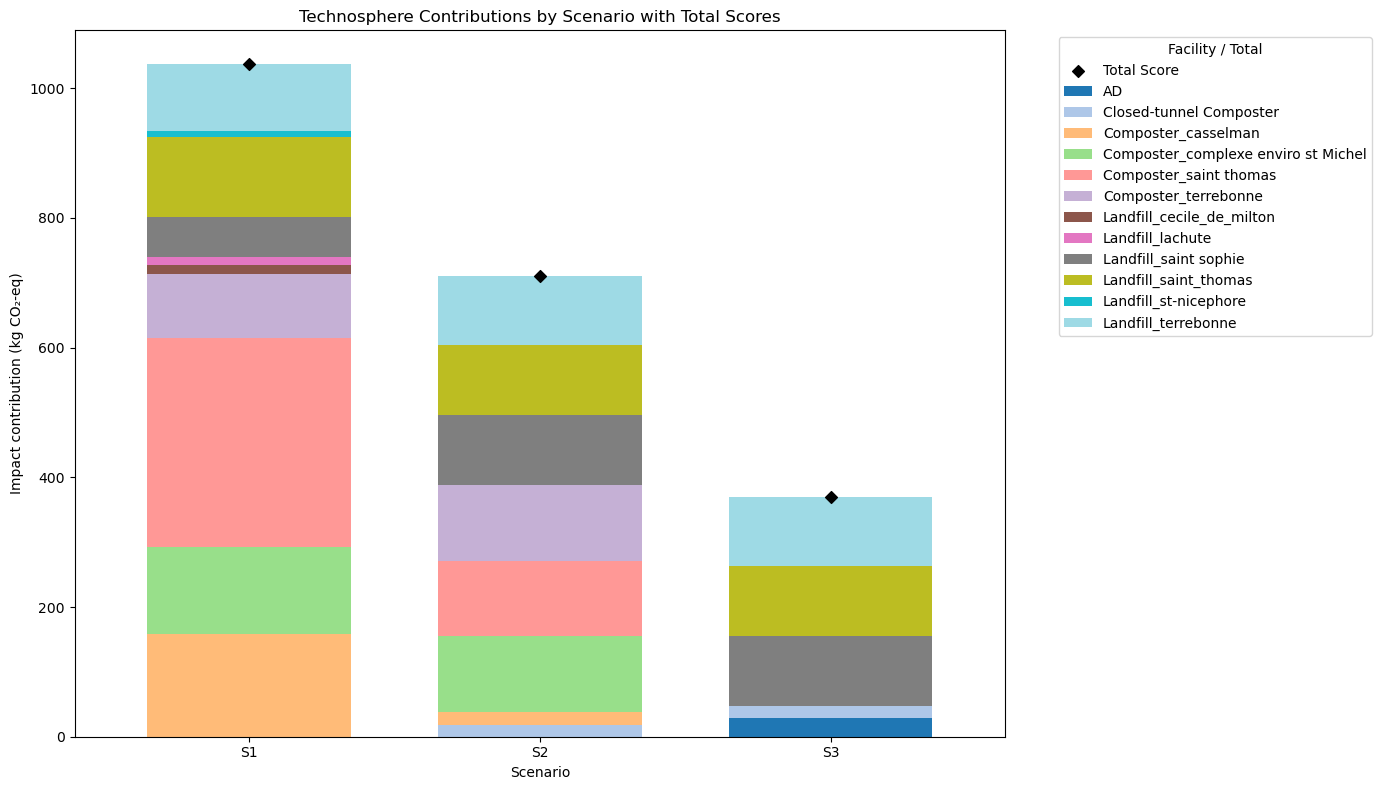

In [ ]:
# Combine contribution data for all scenarios into one DataFrame
all_scenarios_df = []

for act in acts:
    scenario_name = act['name']
    df_temp = pd.DataFrame(ca_dict[scenario_name], columns=['name', 'input', 'type', 'amount', 'contribution'])
    df_temp = df_temp[df_temp['type'] == 'technosphere'].copy()
    df_temp['Scenario'] = scenario_name  # Add scenario label
    all_scenarios_df.append(df_temp)

# Combine into a single DataFrame
combined_df = pd.concat(all_scenarios_df, ignore_index=True)

# Pivot the table: index = Scenario, columns = facility/process names, values = contribution
pivot_df = combined_df.pivot_table(index='Scenario', columns='name', values='contribution', aggfunc='sum')
pivot_df = pivot_df.fillna(0)  # Replace NaN with 0s

# Step 1: Plot the stacked bar chart
ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='tab20',
    width=0.7
)

# Step 2: Overlay diamond markers for total scores
# If you already have total scores in the same order as scenarios:
# Get scenario names from the pivot index
scenario_names = pivot_df.index.tolist()

# Get total impact scores from the MultiLCA object
total_scores = [mylca.results[i][0] for i in range(len(scenario_names))]  # assumes 1 method, 3 scenarios

# Plot diamonds on top of each bar
for i, score in enumerate(total_scores):
    ax.scatter(
        i,                     # x-position (bar index)
        score,                 # y-position (total impact score)
        marker='D',            # Diamond marker
        color='black',
        label='Total Score' if i == 0 else "",  # only label once for legend
        zorder=5
    )

# Step 3: Beautify the plot
plt.title('Technosphere Contributions by Scenario with Total Scores')
plt.xlabel('Scenario')
plt.ylabel('Impact contribution (kg CO₂-eq)')
plt.xticks(rotation=0)
plt.legend(title='Facility / Total', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Monte Carlo LCA

Adapted from:
https://github.com/massimopizzol/advanced-lca-notebooks/blob/main/Course-material/6-Comparative-Monte-Carlo.ipynb

this could also be helpful (from cmutel)
https://github.com/brightway-lca/brightway2/blob/master/notebooks/Monte%20Carlo%20from%20Excel%20import.ipynb

In [16]:
from bw2data.utils import uncertainify
from stats_arrays import NormalUncertainty
uncertain_db = bw.Database("OWM Facilities")
uncertain_db.write(
    uncertain_db.relabel_data(
        uncertainify(
            bw.Database("OWM Facilities").load(), 
            NormalUncertainty
        ), 
        "OWM Facilities" 
    )
)

Writing activities to SQLite3 database:
0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 06/03/2025 14:55:20
  Finished: 06/03/2025 14:55:20
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 3.07


In [17]:
db = bw.Database('OWM Facilities')
act_MC = [a for a in db if 'Landfill_terrebonne' in a ['name']][0]
act_MC

'Landfill_terrebonne' (tonne, CA-QC, None)

In [18]:
FU = {act_MC:1}
ipcc = ('IPCC 2013', 'climate change', 'global warming potential (GWP100)')
lca = bw.LCA(FU, ipcc)
lca.lci()
lca.lcia()
lca.score

489.86044833632894

In [19]:
mc = bw.MonteCarloLCA(FU, ipcc)
mc_results = [next(mc) for x in range(10)] # will take a bit of time, we are randomly sampling ecoinvent 100 times

489.86044833632894

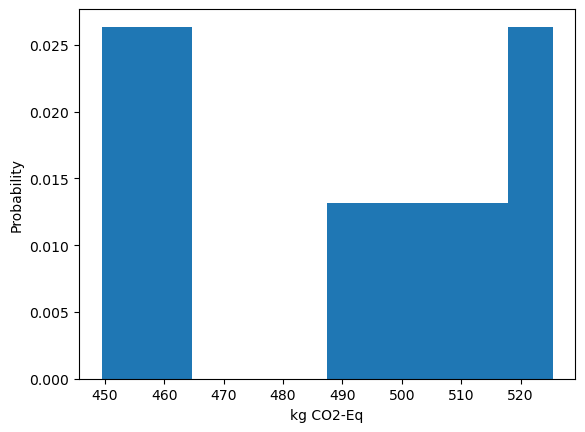

In [20]:
# plot MC results
plt.hist(mc_results, density=True)
plt.ylabel("Probability")
plt.xlabel(bw.methods[ipcc]["unit"])
pd.DataFrame(mc_results).describe() 
lca.score